<a href="https://colab.research.google.com/github/tercasaskova311/Crosslinguistics_emotional_expression/blob/main/Implementation_of_EmoAtlas_Mistral_Hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Objective
To compare the emotional intensity of responses generated by a language model (LLM) when prompted in Italian vs. English, using EmoAtlas as the emotion analysis tool.
The broader goal is to explore whether the language of the prompt affects the emotional expression in the LLM’s response — a kind of multilingual sentiment audit.

#Theme

We're using EmoAtlas, a tool that quantifies emotional signals in text, to investigate how the same idea, when phrased in different languages, may trigger different emotional profiles in the model's replies.
This fits under the broader theme:
Analyzing LLM self-expression across languages using emotion metrics.

# Approach


Prompt Construction:
Choose a small set of emotionally neutral or ambiguous phrases.
Translate each phrase directly into both Italian and English.
Use these as prompts for the LLM.
LLM Response Collection:
Query the LLM with each prompt.
Collect its full response in both languages.

Emotion Scoring:
Use emos_eng.zscores() and emos_it.zscores() (from EmoAtlas) to compute the emotional intensity vector for each response.

Expand these vectors into separate columns (e.g., anger, joy, trust, etc.) to compare emotion-by-emotion.
Comparison & Visualization:
Compare scores across languages.
Optionally visualize via bar plots or radar charts for easy interpretation.


# Prompts

A file with the promtps in each language.


# Step 1: Mistral



In [ ]:
import requests  # For sending HTTP requests
import json      # For handling JSON data

# ==================== Configuration ====================
# Replace with your actual Mistral API key!!!
API_KEY = "671n3ZdhWoz3H28F7XVz7UZjLvieH5jI"

# Base URL for Mistral's OpenAI-compatible chat completions endpoint
API_URL = "https://api.mistral.ai/v1/chat/completions"

# Choose one of the available models (e.g., 'mistral-tiny', 'mistral-small', 'mistral-medium')
MODEL = "mistral-small"

# Headers for authentication and content type
HEADERS = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

# ==================== Function to Send a Chat Message ====================
def chat_with_mistral(messages):
    """
    Sends a list of messages to the Mistral chat API and returns the assistant's response.

    Parameters:
        messages (list): A list of message dictionaries in the OpenAI chat format.
                         Example: [{"role": "user", "content": "Hello!"}]

    Returns:
        str: The assistant's reply as a string.
    """
    payload = {
        "model": MODEL,
        "messages": messages,
        "temperature": 0.7,     # Creativity level (0 = deterministic, 1 = more random)
        "top_p": 1.0,           # Nucleus sampling parameter
        "stream": False         # Disable streaming for simple usage
    }

    # Send a POST request to Mistral's API
    response = requests.post(API_URL, headers=HEADERS, data=json.dumps(payload))

    # Raise an error if the request failed
    if response.status_code != 200:
        raise Exception(f"Request failed: {response.status_code} - {response.text}")

    # Parse the JSON response
    response_data = response.json()

    # Extract and return the assistant's reply
    return response_data['choices'][0]['message']['content']

In [ ]:
chat_history_eng = [
    {"role": "user",
     "content":"I want to make multiple prompts to an LLM with the same phrase in english and italian, and I want to use a json file. I need 70 phrases, each needs to ask for opinions. Can you make that json for me, with all the 70 phrases?"}
]

try:
    response = chat_with_mistral(chat_history_eng)
    print(response)
except Exception as e:
    print("Error:", str(e))

Sure, here is a JSON file with 70 phrases in English and Italian seeking opinions:

```json
{
  "prompts": [
    {
      "english": "What do you think about the current political situation in the US?",
      "italian": "Che ne pensi della situazione politica attuale negli Stati Uniti?"
    },
    {
      "english": "Do you like Italian cuisine? What is your favorite dish?",
      "italian": "Ti piace la cucina italiana? Qual è il tuo piatto preferito?"
    },
    {
      "english": "What do you think about the use of artificial intelligence in our daily lives?",
      "italian": "Che ne pensi dell'utilizzo dell'intelligenza artificiale nelle nostre vite quotidiane?"
    },
    {
      "english": "Which movie have you seen recently that you would recommend?",
      "italian": "Quale film hai visto di recente che consiglieresti?"
    },
    {
      "english": "What is your opinion on climate change and its impact on the environment?",
      "italian": "Qual è la tua opinione sui cambiame

In [ ]:
import re

def clean_response_json(response):
  match = re.search(r'```json\s*(.*?)\s*```', response, re.DOTALL)
  if match:
    json_content = match.group(1)
    return json_content
  else:
    print("No JSON content found in the text.")

json_res = json.loads(clean_response_json(response))
json_res

{'prompts': [{'english': 'What do you think about the current political situation in the US?',
   'italian': 'Che ne pensi della situazione politica attuale negli Stati Uniti?'},
  {'english': 'Do you like Italian cuisine? What is your favorite dish?',
   'italian': 'Ti piace la cucina italiana? Qual è il tuo piatto preferito?'},
  {'english': 'What do you think about the use of artificial intelligence in our daily lives?',
   'italian': "Che ne pensi dell'utilizzo dell'intelligenza artificiale nelle nostre vite quotidiane?"},
  {'english': 'Which movie have you seen recently that you would recommend?',
   'italian': 'Quale film hai visto di recente che consiglieresti?'},
  {'english': 'What is your opinion on climate change and its impact on the environment?',
   'italian': "Qual è la tua opinione sui cambiamenti climatici e il loro impatto sull'ambiente?"},
  {'english': 'Do you prefer reading books or watching movies? Why?',
   'italian': 'Preferisci leggere libri o guardare film? P

Iterate the prompts and get the responses on a new json.

In [ ]:
import time
print(len(json_res["prompts"]))

for item in json_res["prompts"]:
  time.sleep(1)
  item["english_response"] = chat_with_mistral([{"role": "user", "content": item["english"]}])
  time.sleep(1)
  item["italian_response"] = chat_with_mistral([{"role": "user", "content": item["italian"]}])

201


# Step 2: Getting emoatlas to work

In [ ]:
!pip install git+https://github.com/MassimoStel/emoatlas

  Cloning https://github.com/MassimoStel/emoatlas to /tmp/pip-req-build-ec1p3013
  Running command git clone --filter=blob:none --quiet https://github.com/MassimoStel/emoatlas /tmp/pip-req-build-ec1p3013
  Resolved https://github.com/MassimoStel/emoatlas to commit b2d807aaf8430a9ee0a7c2b803b33061a4587086
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for emoatlas: filename=emoatlas-0.2.0-py3-none-any.whl size=3766214 sha256=b03ea1260dcfdce760d67c0d2e4ddbe2806bbb4a1e036b46f9215fdf25cdddfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ii2ed0i/wheels/f8/1e/54/1b9f3fd74b7906f753c3ee64aede89fd138b802bb33257d9bf
Successfully built emoatlas


Apparently spacy has no czech, we can ask for a solution maybe.

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download it_core_news_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 787.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import matplotlib
from emoatlas import EmoScores
import emoatlas

In [ ]:
emos_eng = EmoScores(language="english")
emos_it = EmoScores(language="italian")


In [ ]:
import pandas as pd

emotions = ["anger", "joy", "trust", "sadness", "disgust", "fear", "anticipation", "surprise"]


# Function to extract zscores for each emotion
def extract_emotions(df, col_name, model, prefix):
    return pd.DataFrame({
        f"{prefix}_{emotion}": df[col_name].apply(lambda x: model.zscores(x).get(emotion, 0))
        for emotion in emotions
    })
df = pd.DataFrame(json_res["prompts"])

# Extract emotion scores
df_eng = extract_emotions(df, "english_response", emos_eng, "eng")
df_it = extract_emotions(df, "italian_response", emos_it, "it")

# Combine into one DataFrame
df_emotions = pd.concat([df_eng, df_it], axis=1)

In [ ]:
df_emotions.to_csv("/df_emotions_full_ds.csv")

In [ ]:
df_it_sum = df_it.sum()
df_eng_sum = df_eng.sum()

summary_of_each_emotion = pd.DataFrame({
    'Italian': df_it_sum,
    'English': df_eng_sum
})


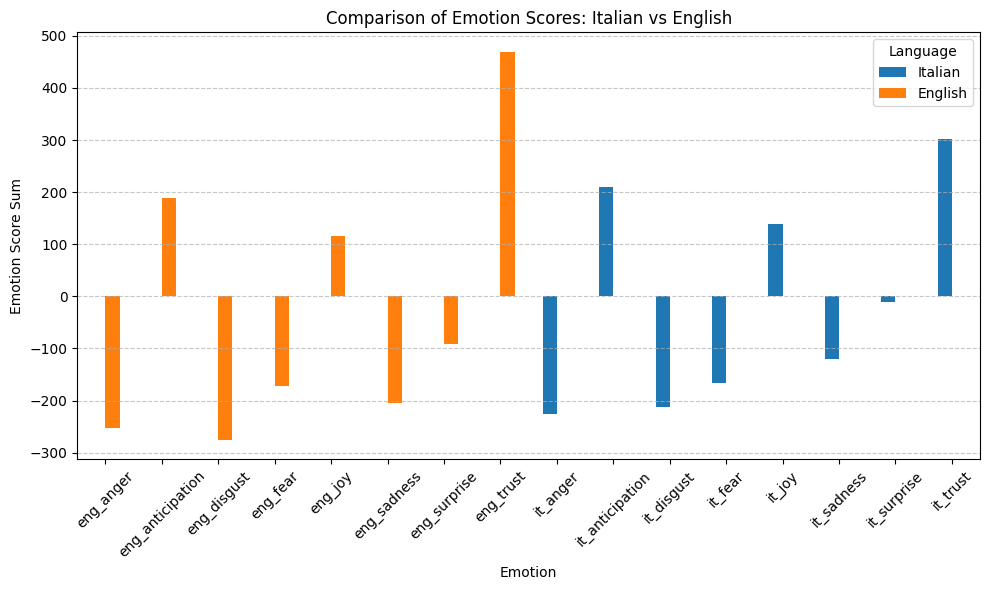

In [ ]:
import matplotlib.pyplot as plt

# Plot
summary_of_each_emotion.plot(kind='bar', figsize=(10, 6))

plt.title("Comparison of Emotion Scores: Italian vs English")
plt.ylabel("Emotion Score Sum")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Language")
plt.tight_layout()
plt.show()

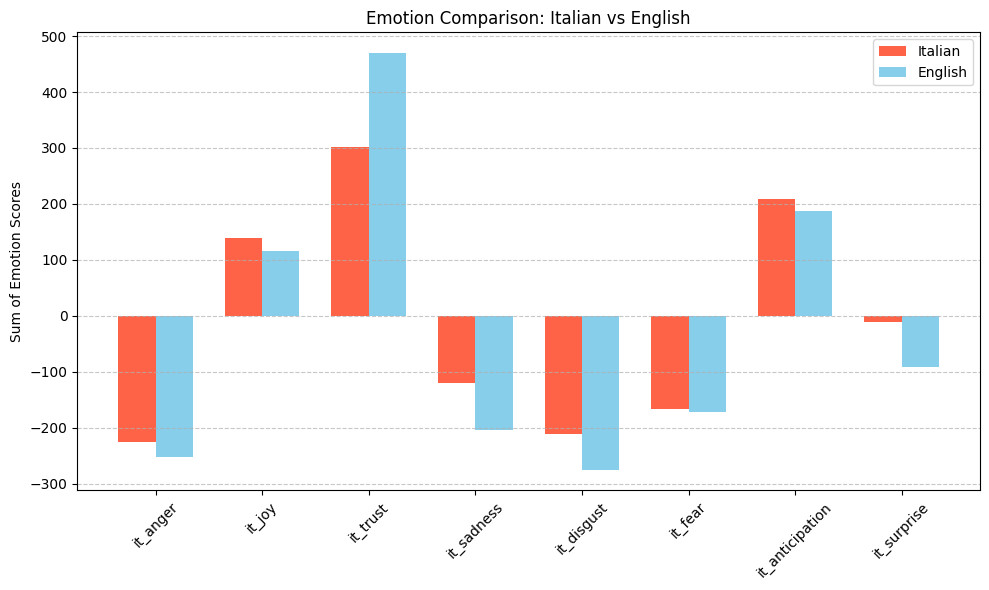

In [ ]:
import numpy as np

it_sum = df_it.sum()
eng_sum = df_eng.sum()

# 2. Set x locations for bars
labels = it_sum.index  # emotion names
x = np.arange(len(labels))  # label locations

width = 0.35  # width of the bars

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, it_sum.values, width, label='Italian', color='tomato')
bars2 = ax.bar(x + width/2, eng_sum.values, width, label='English', color='skyblue')

# 4. Aesthetics
ax.set_ylabel('Sum of Emotion Scores')
ax.set_title('Emotion Comparison: Italian vs English')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
